# Problem Statement and details.

1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
3. How did you select variables to be included in the model?
4. Demonstrate the performance of the model by using best set of tools.
5. What are the key factors that predict fraudulent customer?
6. Do these factors make sense? If yes, How? If not, How not?
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

**Variables In Dataset**

1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

3. amount - amount of the transaction in local currency.

4. nameOrig - customer who started the transaction

5. oldbalanceOrg - initial balance before the transaction

6. newbalanceOrig - new balance after the transaction

7. nameDest - customer who is the recipient of the transaction

8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# Loading dataset From Dive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Copy of Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Understanding Basic nature of the dataset.

### Step

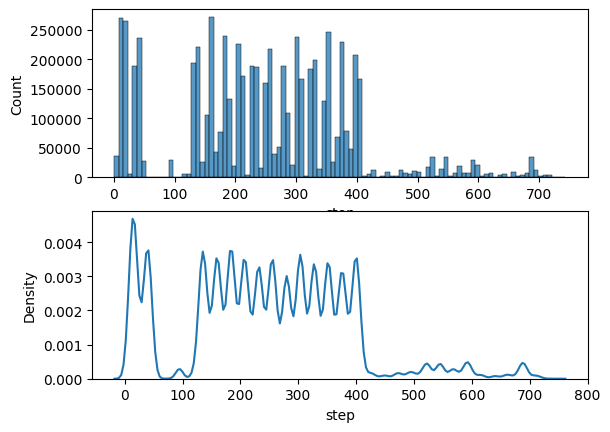

In [3]:
fig, (ax1,ax2) = plt.subplots(2,1)
sns.histplot(data=df,x=df["step"],bins=100,ax=ax1)
sns.kdeplot(data=df,x=df["step"],ax=ax2)
plt.show()

#### Inference

- There is a gap between 80-100 hours, translates to 3rd day to 4 day where there are lesser transactions (comparitavely no transactions.)
- One can clearly see the simulation produced more transactions during the first 18 days. 
- After that simulation steadily decreased.
- May be this due to simulation energy drain, team may pushed to complete test with less available resources compared to early days


### type

In [4]:
valCountsOfType = df["type"].value_counts()

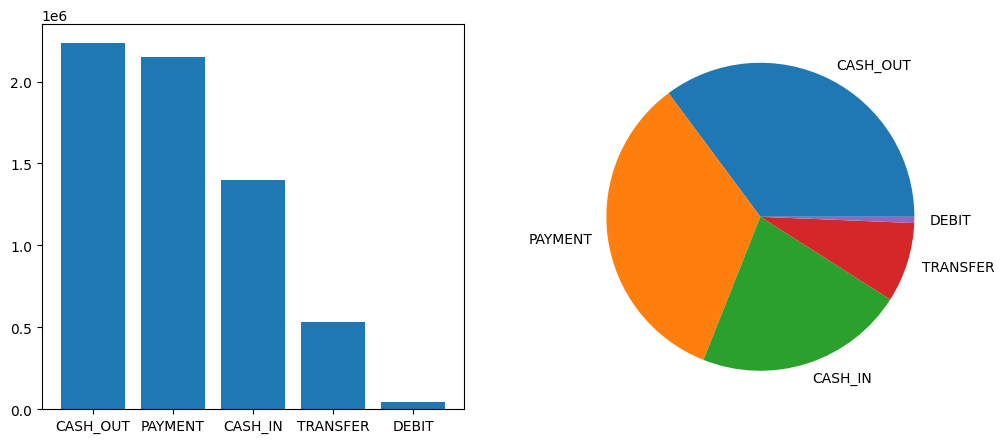

In [5]:
fig , (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
typeDf = valCountsOfType.to_frame().reset_index()
typeDf.columns = ["type","counts"]
ax1.bar(typeDf["type"],typeDf["counts"])
ax2.pie(typeDf["counts"],labels=typeDf["type"])
plt.show()

#### Inference

1. Cash out (Withdrawing amount from one account is most transact.) 
2. Payment which is using for a merchant follows the payment.
3. Simulation does did better job preserving the nature of real dataset, as it many people usually withdraw money and most people in this modern age tend to use payment based services provided by online entities. 
4. Cashing out with debit card is least form of transaction. May be this due to the aim of this study is to predict behaviour of fradulant activites, debit cards have additionally layer of protection like PIN - which 4 or 6 digit combition choosen by user.
5. Payment and cashout dominates.

### amount

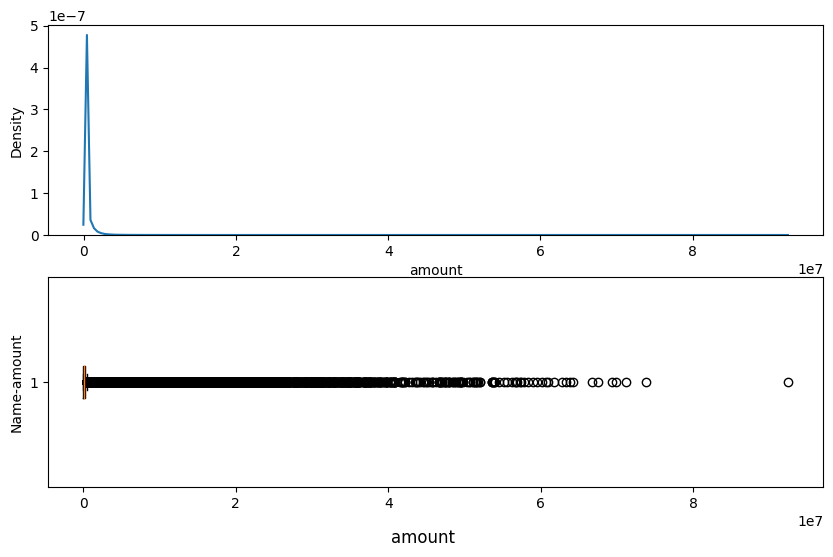

In [6]:
fig3,(ax31,ax32) = plt.subplots(2,1,figsize=(10,6))
fig3.supxlabel("amount")
sns.kdeplot(data=df,ax=ax31,x="amount")
ax32.boxplot(x=df["amount"],vert=False,)
ax32.set_ylabel("Name-amount")
plt.show()

#### Inference

1. This actually stays with our basic understanding most transactions are cash outs, bank limits cash outs of higher payements and which also true for bulk payment for entity.
2. Amount actually depicts transaction amount that owner gices recipient. Which is actually difference of old-balance origin feature to new balance origin.


### Customer id of owner and recipient

In [9]:
UniqueIdForOwners = df["nameOrig"].unique().shape
UniqueIdForRecipents = df["nameDest"].unique().shape
print(f"UniqueIds of owners: {UniqueIdForOwners}, Unique Ids for recipients: ${UniqueIdForRecipents}")

UniqueIds of owners: (6353307,), Unique Ids for recipients: $(2722362,)


Both are high cardinal variables, but they may have unique information that helps the model to learn we can reduce these column by extracting first letter of both columns. 

- M = Merchant 
- C = Customer


In [19]:
print(f'OwnerMissingValues = {df["nameOrig"].isna().sum()}, DistMissingValues = {df["nameDest"].isna().sum()}')

OwnerMissingValues = 0, DistMissingValues = 0


In [11]:
labelNameOrig = df["nameOrig"].copy()
labelNameOrig = labelNameOrig.map(lambda x: x[0])

In [13]:
labelNameOrig.unique()

array(['C'], dtype=object)

In [15]:
labelDistOrig = df["nameDest"].copy()
labelDistOrig = labelDistOrig.map(lambda x: x[0])

In [21]:
labelDistOrig.unique()

array(['M', 'C'], dtype=object)

In [23]:
transactionSingleColDf = pd.DataFrame({})

In [24]:
transactionSingleColDf["transactionLabel"] = labelNameOrig + '-'+ labelDistOrig
transactionSingleColDf

,transactionLabel
0,C-M
1,C-M
2,C-C
3,C-C
4,C-M
...,...
6362615,C-C
6362616,C-C
6362617,C-C
6362618,C-C


In [32]:
df["transaction_label"] = transactionSingleColDf["transactionLabel"]
df.drop(columns = ["nameOrig","nameDest"], inplace=True)

In [33]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transaction_label
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,C-M
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,C-M
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,C-C
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,C-C
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,C-M


In [36]:
valCountsOfTransaction = df["transaction_label"].value_counts()
valCountsOfTransaction

C-C    4211125
C-M    2151495
Name: transaction_label, dtype: int64

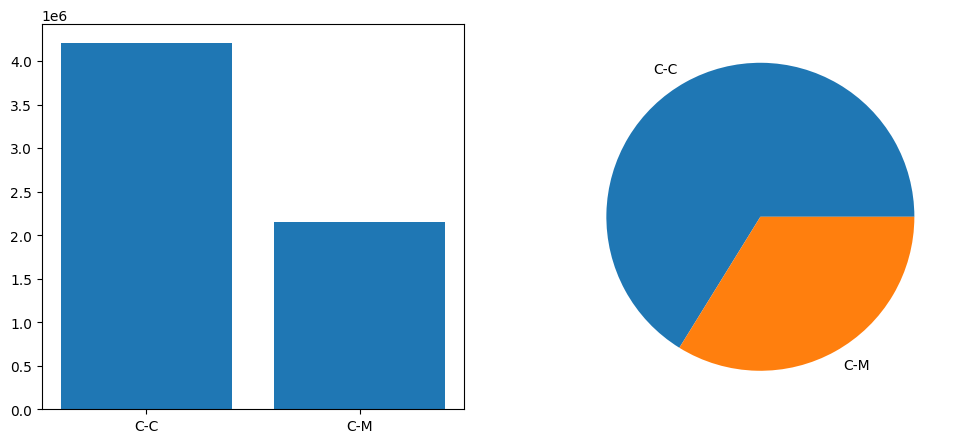

In [42]:

fig , (ax41, ax42) = plt.subplots(1,2,figsize=(12,5))
TransactionDf = valCountsOfTransaction.to_frame().reset_index()
TransactionDf.columns = ["transaction_label","counts"]
ax41.bar(TransactionDf["transaction_label"],TransactionDf["counts"])
ax42.pie(TransactionDf["counts"],labels=TransactionDf["transaction_label"])
plt.show()

#### Inference

- We can clearly transaction between customer - customer is greater than c-m, this is because the nameOrigin only name customer in its column
- The cardinality is decreased crucially also we able to establisg some patterns in the dataset.